In [1]:
import copy
import random
import numpy as np
from typing import List, Dict
import matplotlib.pyplot as plt

class Subnet:
    def __init__( self, tao_reserve: float, alpha_reserve: float, alpha_outstanding:float, is_root: bool = False ):
        self.tao_reserve = tao_reserve
        self.alpha_reserve = alpha_reserve
        self.alpha_outstanding = alpha_outstanding
        self.is_root = is_root
        self.k = tao_reserve * alpha_reserve if not self.is_root else 0
        
    def state(self) -> Dict:
        return {
            "tao_reserve": copy.deepcopy(self.tao_reserve),
            "alpha_reserve": copy.deepcopy(self.alpha_reserve),
            "alpha_outstanding": copy.deepcopy(self.alpha_outstanding),
            "is_root": copy.deepcopy(self.is_root),
            "k": copy.deepcopy(self.k),
            "alpha_price": self.alpha_price(),
        }
        
    def __str__( self ):
        return f"Subnet( price={self.alpha_price()}, tao_reserve={self.tao_reserve}, alpha_reserve={self.alpha_reserve}, alpha_outstanding={self.alpha_outstanding})"
    
    def __repr__(self) -> str:
        return self.__str__()
        
    def tao_price( self ) -> List[ float ]: 
        if self.is_root or self.tao_reserve == 0:
            return 1.0
        return self.alpha_reserve / self.tao_reserve

    def alpha_price( self ) -> List[ float ]: 
        if self.is_root or self.alpha_reserve == 0:
            return 1.0
        return self.tao_reserve / self.alpha_reserve

    def marketcap( self ) -> List[ float ]:
        if self.is_root:
            return 0
        alpha_price = self.alpha_price()
        if alpha_price == 0:
            return 0
        return (self.alpha_outstanding + self.alpha_reserve) * alpha_price

    def weight( self, alpha_amount: float ) -> float: 
        if self.is_root:
            return alpha_amount
        if self.alpha_outstanding == 0:
            return 0
        return (alpha_amount / self.alpha_outstanding) * self.tao_reserve
    
    def inject( self, tao_amount: float, alpha_amount: float, alpha_outstanding: float ):
        self.tao_reserve += tao_amount
        self.alpha_reserve += alpha_amount
        self.alpha_outstanding += alpha_outstanding
        self.k = self.tao_reserve * self.alpha_reserve
        
    def stake( self, tao_amount: float ):
        if self.is_root:
            self.alpha_outstanding += tao_amount
            return tao_amount
        new_tao_reserve_b = self.tao_reserve + tao_amount
        new_alpha_reserve_b = self.k / new_tao_reserve_b
        alpha_bought_b = self.alpha_reserve - new_alpha_reserve_b
        self.alpha_outstanding += alpha_bought_b
        self.alpha_reserve = new_alpha_reserve_b
        self.tao_reserve = new_tao_reserve_b
        return alpha_bought_b
    
    def unstake( self, alpha_amount:float ):
        if self.is_root:
            self.alpha_outstanding -= alpha_amount
            return alpha_amount
        new_alpha_reserve_a = self.alpha_reserve + alpha_amount
        new_tao_reserve_a = self.k / new_alpha_reserve_a
        tao_bought_a = self.tao_reserve - new_tao_reserve_a
        self.alpha_outstanding -= alpha_amount
        self.alpha_reserve = new_alpha_reserve_a
        self.tao_reserve = new_tao_reserve_a
        return tao_bought_a

class Subtensor:
    def __init__( self, 
            n_subnets: int = 3, 
            m_accounts: int = 5,
            tao_supply: float = 6000000, 
            initial_tao_reserve: float = 1000,
            global_split: float = 0.99,
            balanced: bool = False,
            root_weight: float = 1.0,
        ):
        self.n_subnets = n_subnets
        self.m_accounts = m_accounts
        self.global_split = global_split
        self.tao_supply = tao_supply
        self.balanced = balanced
        self.root_weight = root_weight
        self.subnets = [ Subnet( 0, 0, self.tao_supply, is_root=True ) ] + [ Subnet( initial_tao_reserve, initial_tao_reserve * (self.n_subnets-1), 0 ) for _ in range(self.n_subnets-1) ]
        self.tao_accounts = [ 0 for _ in range(self.m_accounts)]
        self.alpha_accounts = [ [self.tao_supply/self.m_accounts for _ in range(self.m_accounts)]] + [ [ 0 for _ in range(self.m_accounts) ] for _ in range(self.n_subnets-1) ]
        self._initial_accounts = copy.deepcopy(self.alpha_accounts)
        
    def state(self) -> Dict:
        return {
            "global_split": copy.deepcopy(self.global_split),
            "tao_supply": copy.deepcopy(self.tao_supply),
            "tao_accounts": copy.deepcopy(self.tao_accounts),
            "alpha_accounts": copy.deepcopy(self.alpha_accounts),
            "subnets": [ subnet.state() for subnet in self.subnets ],
            "sum_prices": self.sum_prices(),
            "weights": self.weights(),
            "values": self.values(),
            "total_dividends": self.total_dividends(),
        }
        
    def __str__( self ):
        st = "Subtensor(\n"
        st += f"\tGlobal Split: {self.global_split}\n"
        st += f"\tTao Supply: {self.tao_supply}\n"
        st += f"\tPool Reserves: {sum([self.subnets[i].tao_reserve for i in range(self.n_subnets)])}\n"
        st += f"\tAccount Weights: {self.weights()}\n"
        st += f"\tAccount Values: {self.values()}\n"
        st += '\n\t' + '\n\t'.join([f"Accounts On Subnet:{i}: {self.alpha_accounts[i]}" for i in range(len(self.alpha_accounts))]) + '\n'
        st += '\n\t' + '\n\t'.join([f"Subnet {i}: {self.subnets[i]}" for i in range(self.n_subnets)])
        st += "\n)"
        return st
    
    def sum_prices(self) -> float:
        return sum( [ self.subnets[i].alpha_price() for i in range(1, self.n_subnets) ] )
    
    def weights(self) -> List[float]:
        weights = []
        for acc_i in range(self.m_accounts):
            weights.append( 0 )
            for subnet_i in range(0, self.n_subnets):
                if subnet_i == 0:
                    weights[-1] += self.subnets[ subnet_i ].weight( self.alpha_accounts[ subnet_i ][ acc_i ] * self.root_weight )
                else:
                    weights[-1] += self.subnets[ subnet_i ].weight( self.alpha_accounts[ subnet_i ][ acc_i ] )
        return weights
       
    def values(self) -> List[float]:
        return [ sum([ (self.subnets[ subnet_i ].alpha_price() * self.alpha_accounts[ subnet_i ][ acc_i ] ) for subnet_i in range(self.n_subnets) ]) for acc_i in range(self.m_accounts) ]
    
    def total_dividends(self ) -> float:
        total_divs = [ 0 for _ in range(self.m_accounts) ]
        for i in range(self.n_subnets):
            if i == 0: continue
            dividends = self.dividends( i )
            for acc_i in range(self.m_accounts):
                total_divs[ acc_i ] += dividends[ acc_i ] * self.subnets[i].alpha_price()
        return total_divs
        
    def dividends(self, subnet_i: int ) -> float:
        local_weight = [ self.subnets[subnet_i].weight( self.alpha_accounts[ subnet_i ][ acc_i ] ) for acc_i in range(self.m_accounts) ]
        local_weight = [ w / sum(local_weight) if sum(local_weight) != 0 else 0 for w in local_weight ]
        
        global_weight = self.weights()
        global_weight = [ w / sum(global_weight) if sum(global_weight) != 0 else 0 for w in global_weight ]

        return [ (self.global_split * global_weight[ acc_i] + (1 - self.global_split) * local_weight[acc_i]) for acc_i in range(self.m_accounts) ]
        
    def emission( self ) -> List[ float ]:
        emission = [ self.subnets[i].tao_reserve for i in range(self.n_subnets) ]
        emission = [ (e / sum(emission)) for e in emission ]
        return emission        
    
    def stake(self, subnet_i: int, account_j: int, tao_amount: float ) -> float:
        assert subnet_i < self.n_subnets, "Subnet index out of range"
        assert account_j < self.m_accounts, "Account index out of range"
        assert tao_amount <= self.tao_accounts[account_j], "Insufficient funds"
        alpha_bought = self.subnets[subnet_i].stake( tao_amount )
        self.alpha_accounts[subnet_i][account_j] += alpha_bought
        self.tao_accounts[account_j] -= tao_amount
        return alpha_bought
    
    def unstake(self, subnet_i: int, account_j: int, alpha_amount: float ) -> float:
        assert subnet_i < self.n_subnets, "Subnet index out of range"
        assert account_j < self.m_accounts, "Account index out of range"
        assert alpha_amount <= self.alpha_accounts[subnet_i][account_j], "Insufficient funds"
        tao_bought = self.subnets[subnet_i].unstake( alpha_amount )
        self.alpha_accounts[subnet_i][account_j] -= alpha_amount
        self.tao_accounts[account_j] += tao_bought
        return tao_bought

    def block_step( self, n_blocks: int = 1 ):
        emission = self.emission()
        sum_prices = self.sum_prices()
        self.tao_supply += n_blocks if sum_prices < 1.0 or not self.balanced else 0
        for subnet_i in range(self.n_subnets):
            if subnet_i == 0: continue
            self.subnets[ subnet_i ].inject( 
                tao_amount = emission[ subnet_i ] * n_blocks if sum_prices < 1.0 or not self.balanced else 0, 
                alpha_amount = 1 * n_blocks if sum_prices < 1.0 or not self.balanced else 1 * n_blocks * 1,
                alpha_outstanding = 1 * n_blocks
            )
            dividends = self.dividends( subnet_i ) 
            for acc_i in range(self.m_accounts):
                self.alpha_accounts[ subnet_i ][ acc_i ] += dividends[ acc_i ] * n_blocks
                        

Initial State
 Subtensor(
	Global Split: 0.5
	Tao Supply: 7500000
	Pool Reserves: 9000
	Account Weights: [1500000.0, 1500000.0, 1500000.0, 1500000.0, 1500000.0]
	Account Values: [1500000.0, 1500000.0, 1500000.0, 1500000.0, 1500000.0]

	Accounts On Subnet:0: [1500000.0, 1500000.0, 1500000.0, 1500000.0, 1500000.0]
	Accounts On Subnet:1: [0, 0, 0, 0, 0]
	Accounts On Subnet:2: [0, 0, 0, 0, 0]
	Accounts On Subnet:3: [0, 0, 0, 0, 0]
	Accounts On Subnet:4: [0, 0, 0, 0, 0]
	Accounts On Subnet:5: [0, 0, 0, 0, 0]
	Accounts On Subnet:6: [0, 0, 0, 0, 0]
	Accounts On Subnet:7: [0, 0, 0, 0, 0]
	Accounts On Subnet:8: [0, 0, 0, 0, 0]
	Accounts On Subnet:9: [0, 0, 0, 0, 0]

	Subnet 0: Subnet( price=1.0, tao_reserve=0, alpha_reserve=0, alpha_outstanding=7500000)
	Subnet 1: Subnet( price=0.1111111111111111, tao_reserve=1000, alpha_reserve=9000, alpha_outstanding=0)
	Subnet 2: Subnet( price=0.1111111111111111, tao_reserve=1000, alpha_reserve=9000, alpha_outstanding=0)
	Subnet 3: Subnet( price=0.1111111111

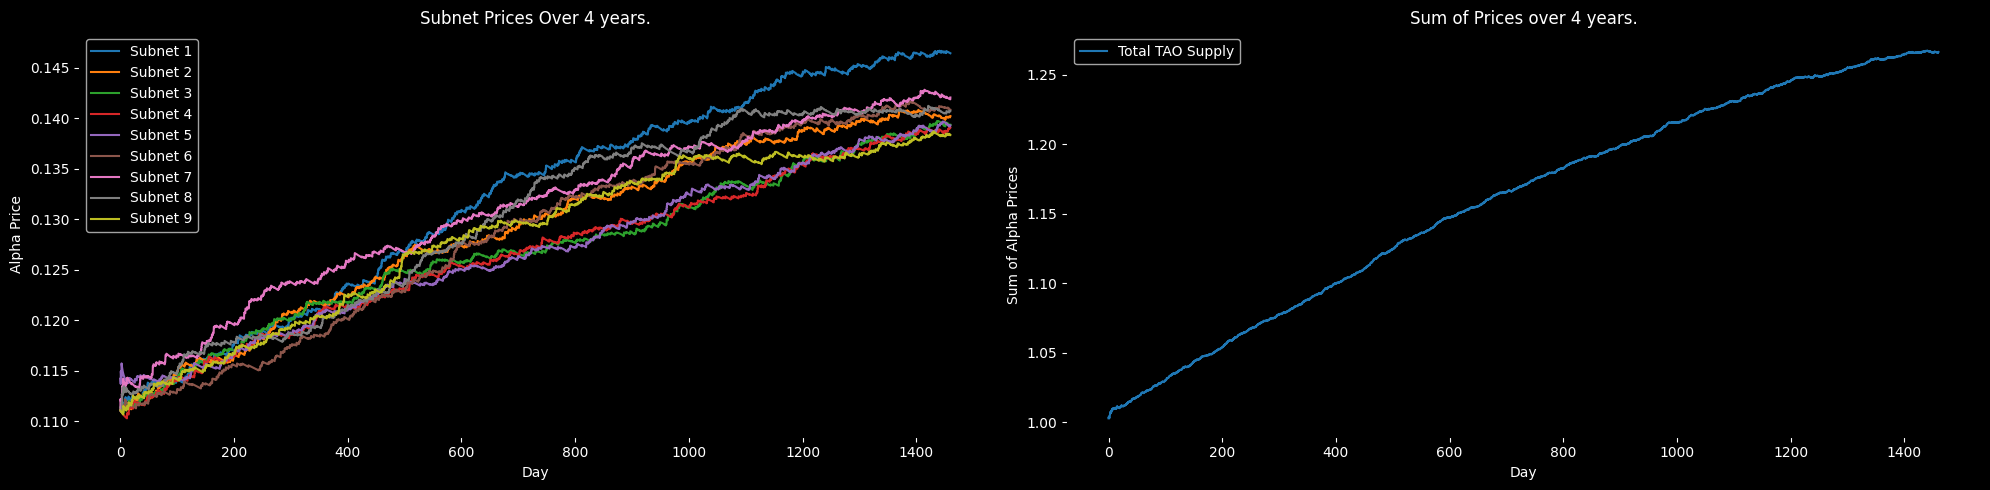

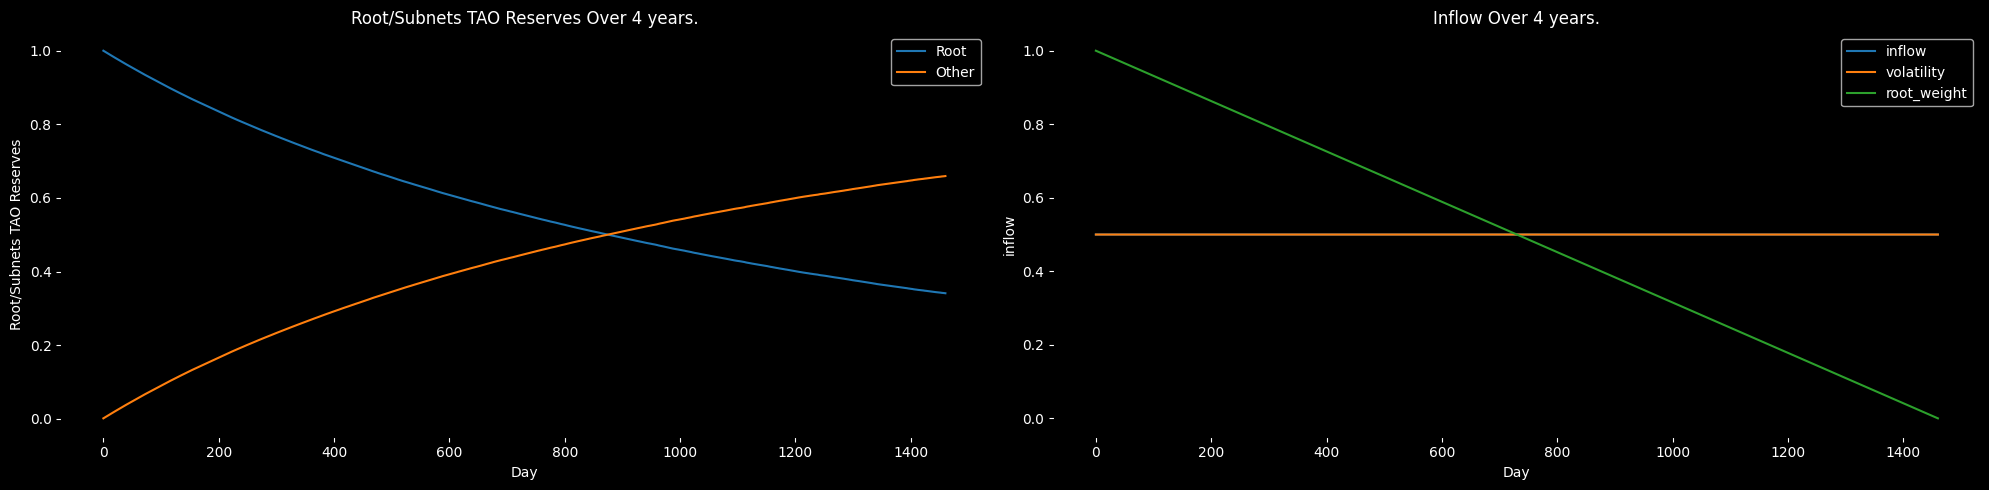

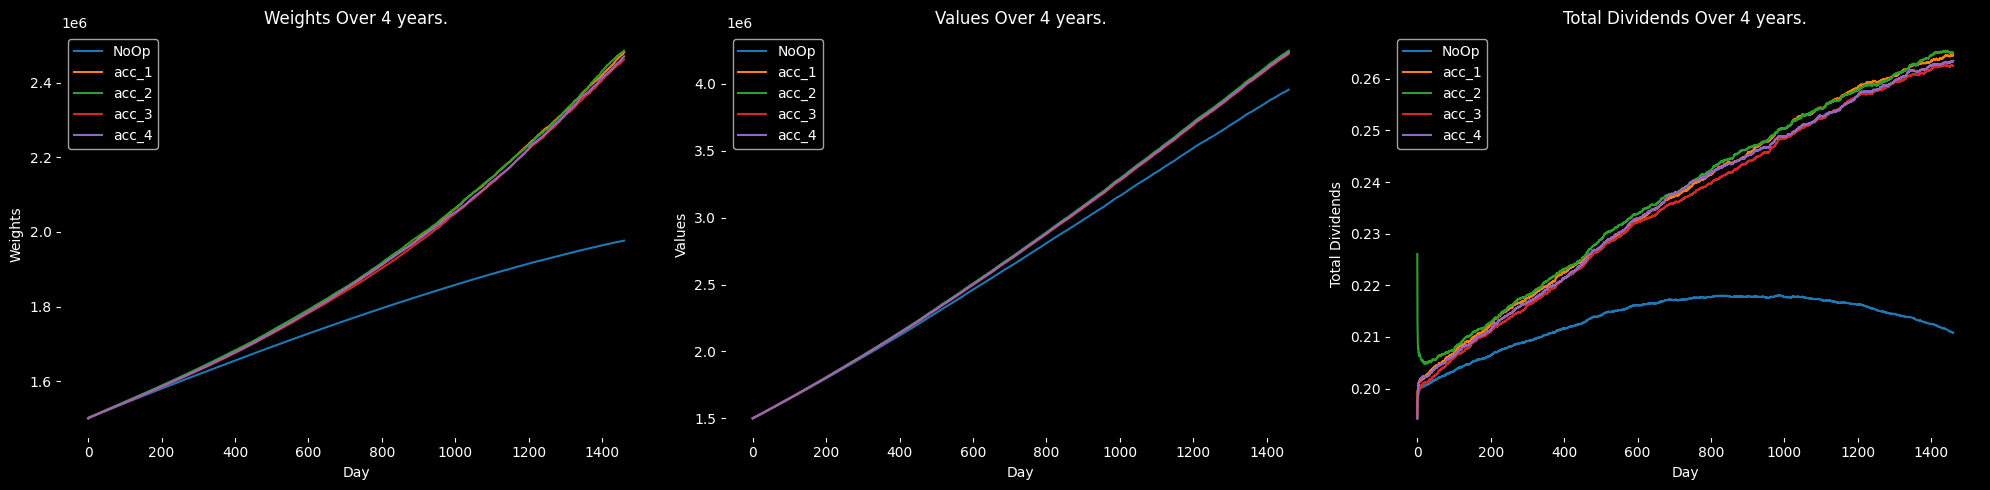

Final state:
 Subtensor(
	Global Split: 0.5
	Tao Supply: 18010000
	Pool Reserves: 11875717.510157483
	Account Weights: [np.float64(1976847.6320864197), np.float64(2481067.679357497), np.float64(2485319.3496310157), np.float64(2461585.0077612987), np.float64(2470421.2257959265)]
	Account Values: [np.float64(3956189.295832581), np.float64(4240229.045520114), np.float64(4247791.3942933045), np.float64(4222771.522732697), np.float64(4231702.953194465)]

	Accounts On Subnet:0: [1500000.0, np.float64(1157537.080662245), np.float64(1159820.83328388), np.float64(1163869.7069611943), np.float64(1162054.868935191)]
	Accounts On Subnet:1: [np.float64(1931928.253081691), np.float64(2420751.0179446377), np.float64(2437625.272398222), np.float64(2515466.1008940646), np.float64(2456056.614096722)]
	Accounts On Subnet:2: [np.float64(1939497.840784984), np.float64(2465512.0378129515), np.float64(2459500.6504566865), np.float64(2406757.450380771), np.float64(2361684.1331802676)]
	Accounts On Subnet:3: [

In [2]:

# Init the network state
n_subnets = 10 # 1 root + 9 subnets
# 10 mock accounts. 
m_accounts = 5
# 50% of the dividends from global weight vs local, more global weight means subnet tokens provide less dividends.
global_split = 0.5
# Initial TAO supply: all of this TAO is evenly distributed across the accounts on root.
initial_tao_supply = 7_500_000
# Initial TAO reserve for the root subnet (potentially from the lock cost.)
initial_tao_reserve = 1000
# If true, the subtensor contract will stop the inflation of TAO if the prices exceed 1.0. This is to simulate a deflationary mechanism.
# If false, the inflation will continue even if the prices exceed 1.0.
balanced = False
# Construct the subtensor object which holds the pools for each subnet as well as account balances.
subtensor = Subtensor( 
    n_subnets = n_subnets, 
    m_accounts = m_accounts, 
    tao_supply = initial_tao_supply, 
    initial_tao_reserve = initial_tao_reserve,
    global_split = global_split,
    balanced = balanced,
    root_weight=1.0,
)
# Print the initial state of the network
print ('Initial State\n', subtensor)

# Simulate the network over time
# History will store the subtensor contract state at each step.
history = [] 
# Number of steps to simulate the time period for, fewer steps will simulate faster but with less granularity.
n_steps = 10000
# Simulate for x years, 7200 * 365 blocks per year.
years = 4
# Number of days we are simulating in total.
n_days = years * 365
# Number of random swaps that occur each step either from root -> subnets or subnets -> root.
swaps_per_step = 1
# Number of blocks per step, this is the number of blocks that are processed in each step.
blocks_per_step = int( 7200 * n_days / n_steps )
# Simulate the network over time
# n_steps = 10
steps = list(range( n_steps ))
# Volatility: The proportion of the account's balance that is swapped in each step.
# As this increases, the prices will have more volatility.
max_volatility = 0.001
min_volatility = 0.00001
step_volatility = np.linspace(min_volatility, max_volatility, n_steps)
# Inflow: the probability of a swap being from root -> subnets or subnets -> root.
# As this increases, token prices are likely to increase and root tao will decrease.
start_inflow = 0.5
stop_inflow = 0.5
step_inflow = np.linspace(start_inflow, stop_inflow, n_steps)
# Root Weight: the weight of the root account in the global weight calculation.
# As this decreases, purely holding root TAO becomes less valuable.
start_root = 1.0
end_root = 0.0
step_root_weight = np.linspace(start_root, end_root, n_steps)
# Run the simulation.
for step in steps:

    # For each swap, randomly select a subnet and account to swap with.
    subtensor.root_weight = step_root_weight[step]
    for _ in range(swaps_per_step):
        subnet_i = random.choice( range( 1, subtensor.n_subnets ) )
        acc_j = random.choice( range( 1, subtensor.m_accounts ) )

        # Randomly select if the swap is from root -> subnets or subnets -> root.
        if random.random() > step_inflow[step]:
            # Unstake a random amount of TAO from the subnet and stake it in the root.
            # alpha_amount = random.uniform(0, subtensor.alpha_accounts[ subnet_i ][ acc_j ] * volatility )
            alpha_amount = random.uniform(0, subtensor.alpha_accounts[ subnet_i ][ acc_j ] * step_volatility[step] )
            tao_amount = subtensor.unstake( subnet_i, acc_j, alpha_amount )
            subtensor.stake( 0, acc_j, tao_amount )
        else:
            # Unstake a random amount of TAO from the root and stake it in the subnet.
            # tao_amount = random.uniform(0, subtensor.alpha_accounts[ 0 ][ acc_j ] * volatility )
            tao_amount = random.uniform(0, subtensor.alpha_accounts[ 0 ][ acc_j ] * step_volatility[step] )
            tao_amount = subtensor.unstake( 0, acc_j, tao_amount )
            subtensor.stake( subnet_i, acc_j, tao_amount )

    # Process the block emission for this step distributing TAO to pools and inflating alpha.
    subtensor.block_step( n_blocks = blocks_per_step )
    
    # Save step state.
    state = subtensor.state()
    state['inflow'] = step_inflow[step]
    state['volatility'] = step_inflow[step]
    state['root_weight'] = step_root_weight[step]
    history.append( state )
    
    
start_idx = 0
end_idx = len(history)
xticks = list(np.linspace(0, n_days, len(steps)))
xticks = xticks[start_idx:end_idx]
history = history[start_idx:end_idx]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
fig.patch.set_facecolor('black')

# First subplot - Subnet prices
ax1.set_facecolor('black')
for subnet_i in range(1, n_subnets):
    ax1.plot(xticks, [h["subnets"][subnet_i]["alpha_price"] for h in history], label=f"Subnet {subnet_i}" if subnet_i != 0 else "Root")
ax1.set_xlabel("Day", color='white')
ax1.set_ylabel("Alpha Price", color='white')
ax1.set_title(f"Subnet Prices Over {years} years.", color='white')
ax1.tick_params(colors='white')
ax1.legend(facecolor='black', labelcolor='white')

# Second subplot - Total TAO supply
ax2.set_facecolor('black')
ax2.plot(xticks, [h["sum_prices"] for h in history], label="Total TAO Supply")
ax2.set_xlabel("Day", color='white')
ax2.set_ylabel("Sum of Alpha Prices", color='white')
ax2.set_title(f"Sum of Prices over {years} years.", color='white')
ax2.tick_params(colors='white')
ax2.legend(facecolor='black', labelcolor='white')

plt.tight_layout()
plt.show()

# Plot both graphs side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
fig.patch.set_facecolor('black')

# First subplot - TAO reserves
ax1.set_facecolor('black')
ax1.plot(xticks, [h["subnets"][0]["alpha_outstanding"]/h['tao_supply'] for h in history], label=f"Root")
ax1.plot(xticks, [ sum( [h["subnets"][i]["tao_reserve"] for i in range(n_subnets) ])/h['tao_supply'] for h in history], label=f"Other")
ax1.set_xlabel("Day", color='white')
ax1.set_ylabel("Root/Subnets TAO Reserves", color='white')
ax1.set_title(f"Root/Subnets TAO Reserves Over {years} years.", color='white')
ax1.tick_params(colors='white')
ax1.legend(facecolor='black', labelcolor='white')

# Second subplot - Inflow over time
ax2.set_facecolor('black')
ax2.plot(xticks, [h["inflow"] for h in history], label="inflow")
ax2.plot(xticks, [h["volatility"] for h in history], label="volatility")
ax2.plot(xticks, [h["root_weight"] for h in history], label="root_weight")
ax2.set_xlabel("Day", color='white')
ax2.set_ylabel("inflow", color='white')
ax2.set_title(f"Inflow Over {years} years.", color='white')
ax2.tick_params(colors='white')
ax2.legend(facecolor='black', labelcolor='white')

plt.tight_layout()
plt.show()
# Plot weights and values side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

# First subplot - Weights over time
ax1.set_facecolor('black')
for i in range(m_accounts):
    ax1.plot(xticks, [h["weights"][i] for h in history], label=f"acc_{i}" if i != 0 else "NoOp")
ax1.set_xlabel("Day", color='white')
ax1.set_ylabel("Weights", color='white')
ax1.set_title(f"Weights Over {years} years.", color='white')
ax1.tick_params(colors='white')
ax1.legend(facecolor='black', labelcolor='white')

# Second subplot - Values over time 
ax2.set_facecolor('black')
for i in range(m_accounts):
    ax2.plot(xticks, [h["values"][i] for h in history], label=f"acc_{i}" if i != 0 else "NoOp")
ax2.set_xlabel("Day", color='white')
ax2.set_ylabel("Values", color='white')
ax2.set_title(f"Values Over {years} years.", color='white')
ax2.tick_params(colors='white')
ax2.legend(facecolor='black', labelcolor='white')

# Third subplot - Total dividends over time
ax3.set_facecolor('black')
for i in range(m_accounts):
    ax3.plot(xticks, [h["total_dividends"][i] for h in history], label=f"acc_{i}" if i != 0 else "NoOp")
ax3.set_xlabel("Day", color='white')
ax3.set_ylabel("Total Dividends", color='white')
ax3.set_title(f"Total Dividends Over {years} years.", color='white')
ax3.tick_params(colors='white')
ax3.legend(facecolor='black', labelcolor='white')

fig.patch.set_facecolor('black')
plt.tight_layout()
plt.show()

print( 'Final state:\n', subtensor )

    

